N.N and deep learning
Image recoloring
Shahla Sadeghzadeh - Shayan Sharifi - Mohammad Vanaei

1.first step is importing the needed library

In [18]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from fastai.data.external import untar_data, URLs


Downloading images from COCO
we considered 10000 images which we dedicated 8000 for training and 2
000 for testing


In [19]:

# # coco_path = untar_data(URLs.COCO_SAMPLE)
# # coco_path = str(coco_path) + "/train_sample"
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


2400 600


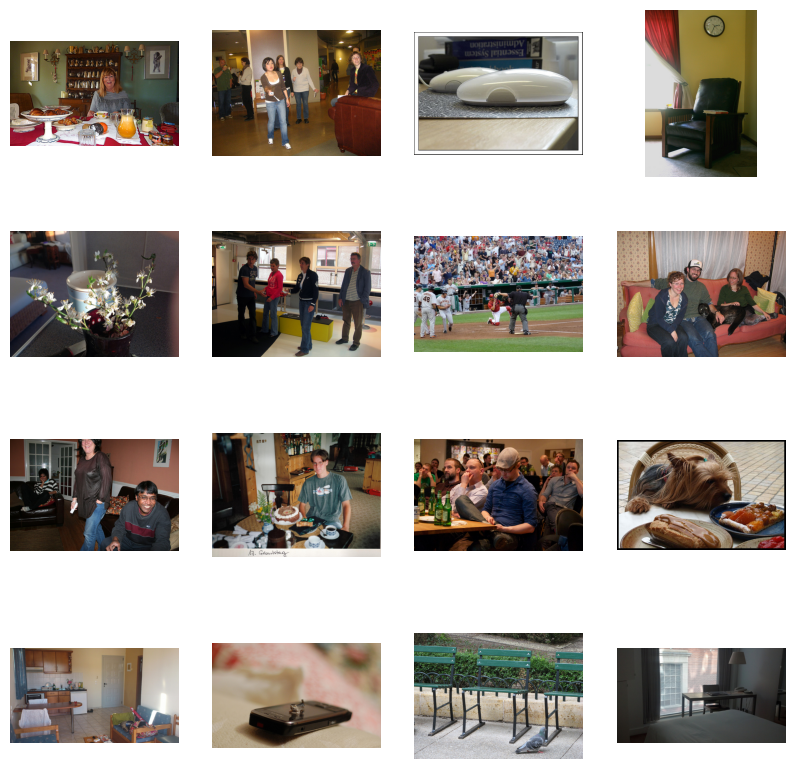

In [20]:

paths=glob.glob("/content/drive/MyDrive/Deep/coco/*.jpg")
#paths = glob.glob("./data/coco_sample/train_sample/*.jpg")
np.random.seed(100)
paths_subset = np.random.choice(paths, 3_000, replace=False) # choosing 1000 images by random
rand_idxs = np.random.permutation(3_000)
train_idxs = rand_idxs[:2400]
val_idxs = rand_idxs[2400:]
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]


print(len(train_paths), len(val_paths))

_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

below code defines a dataset and data loaders for a colorization task using PyTorch. It loads images, converts them to the Lab color space, separates them into luminance (L) and color (ab) channels, and prepares them for training and validation. The data loaders enable efficient batch processing for training a colorization model.
It converts the images to the Lab color space, which consists of three channels: L (luminance), a (green-red color component), and b (blue-yellow color component). The L channel represents the grayscale version of the image, while the a and b channels represent the color information.

In [21]:
SIZE = 256
class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE)),

            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE))

        self.split = split
        self.size = SIZE
        self.paths = paths

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")

        transform1 = transforms.Compose([
          transforms.Resize((SIZE, SIZE)),
          transforms.Grayscale(),  # Convert to grayscale
          transforms.ToTensor()    # Convert to PyTorch tensor
        ])

        # Apply the transform to the image
        gray_img = transform1(img)


        transform2 = transforms.Compose([
          transforms.Resize((SIZE, SIZE)),
          transforms.ToTensor()    # Convert to PyTorch tensor
        ])
        img = transform2(img)


        images = {'img' : img, 'gray_img' : gray_img}
        return images

    def __len__(self):
        return len(self.paths)
#batch_size=16
def make_dataloaders(batch_size=1, n_workers=4, pin_memory=True, **kwargs):
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size)
    return dataloader


train_dl = make_dataloaders(paths=train_paths, split='train')
val_dl = make_dataloaders(paths=val_paths, split='val')

data = next(iter(train_dl))
data['img'].shape


torch.Size([1, 3, 256, 256])

**Config**

In [22]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 1
LEARNING_RATE = 1e-5
LAMBDA_IDENTITY = 0.0
LAMBDA_CYCLE = 10
NUM_WORKERS = 4
NUM_EPOCHS = 20
LOAD_MODEL = False
SAVE_MODEL = True

epochs_loss_G = []
epochs_loss_D = []
epochs_times = []

path_color=glob.glob("/content/drive/MyDrive/Deep/CycleGan/*.jpg")

UNet
 this code defines a U-Net architecture for image segmentation tasks. The U-Net architecture is composed of a series of downsampling (encoding) and upsampling (decoding) blocks, which allow it to capture fine-grained details and spatial information in images /n

the defenition of parameters are below:/n

in_channels: The number of input channels.
out_channels: The number of output channels.
submodule: A submodule to be used inside this block.
input_channels: The number of input channels if not specified (defaults to out_channels).
use_dropout: Whether to use dropout layers.
is_innermost: Indicates if this is the innermost block.
is_outermost: Indicates if this is the outermost block.
/n
Inside the UNetBlock class:

The constructor sets up the block's layers based on the provided parameters.
It includes convolutional layers, activation functions (ReLU or LeakyReLU), and batch normalization.
The block structure varies depending on whether it's innermost, outermost, or a middle block.
The forward method defines the forward pass through this block./n

Define the UNet class:

This class represents the entire U-Net architecture.
It takes parameters for the number of input channels, number of output channels, the number of downscaling steps, and the number of filters to use.
Inside the constructor:
It initializes the innermost block with one downscaling step.
Repeatedly, it adds middle blocks (with optional dropout) according to the specified number of downscaling steps.
Finally, it sets up the outermost block.

inside the UNet class:

The forward method defines the forward pass through the entire U-Net architecture. It passes the input through all the blocks and returns the output.

In [23]:
from torch.nn.utils import spectral_norm

class Generator(torch.nn.Module):
    def __init__(self, in_nc, out_nc, nf=64):
        super(Generator, self).__init__()
        self.input_nc = in_nc
        self.output_nc = out_nc
        self.nf = nf

        self.downconv1 = nn.Sequential(#input H,W 3 output H,W 64  1
            spectral_norm(nn.Conv2d(in_nc, nf, 5, 1, 2)),
            nn.InstanceNorm2d(nf),
            nn.ReLU(True),
        )

        self.downconv2 = nn.Sequential(#input H,W 64 output H/2,W/2 128  2
            spectral_norm(nn.Conv2d(nf, nf * 2, 3, 2, 1)),
            nn.InstanceNorm2d(nf * 2),
            nn.ReLU(True),
        )

        self.downconv3 = nn.Sequential(#input H/2,W/2 128 output H/4,W/4 256  3
            spectral_norm(nn.Conv2d(nf * 2, nf * 4, 3, 2, 1)),
            nn.InstanceNorm2d(nf * 4),
            nn.ReLU(True),
        )

        self.downconv4 = nn.Sequential(# input H/4,W/4 256 output H/8,W/8 512  4
            spectral_norm(nn.Conv2d(nf * 4, nf * 8, 3, 2, 1)),
            nn.InstanceNorm2d(nf * 8),
            nn.ReLU(True),
        )

        self.downconv5 = nn.Sequential(# input H/8,W/8 512 output H/8,W/8 512  5
            spectral_norm(nn.Conv2d(nf * 8, nf * 8, 1, 1)),
            nn.InstanceNorm2d(nf * 8),
            nn.ReLU(True),
        )


        self.upconv3 = nn.Sequential(# input H/8,W/8 1024 output H/4,W/4 256  6
            spectral_norm(nn.ConvTranspose2d(nf * 16, nf * 4, 4, 2, 1)),
            nn.InstanceNorm2d(nf * 4),
            nn.ReLU(True),
        )

        self.upconv2 = nn.Sequential(# input H/4,W/4 512 output H/2,W/2 128  7
            spectral_norm(nn.ConvTranspose2d(nf * 8, nf * 2, 4, 2, 1)),
            nn.InstanceNorm2d(nf * 2),
            nn.ReLU(True),
        )

        self.upconv1 = nn.Sequential(#input H/2,W/2 256 output H,W 3  8
            spectral_norm(nn.ConvTranspose2d(nf * 4, nf, 4, 2, 1)),
            nn.InstanceNorm2d(nf),
            nn.ReLU(True),
            nn.Conv2d(nf, out_nc, 5, 1, 2),
            nn.Tanh(),
        )

        # forward method
    def forward(self, input):

        x1 = self.downconv1(input) #64 H,W
        x2 = self.downconv2(x1) #128 H/2,W/2
        x3 = self.downconv3(x2) #256 H/4,W/4
        x4 = self.downconv4(x3) #512 H/8,W/8
        x5 = self.downconv5(x4) #512 H/8,W/8

        y3 = self.upconv3(torch.cat([x4, x5], dim=1)) #256 H/4,W/4
        y2 = self.upconv2(torch.cat([y3, x3], dim=1)) #128 H/2,W/2
        y1 = self.upconv1(torch.cat([y2, x2], dim=1)) #64 H,W
        output = y1

        return output

In [24]:

class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
        super().__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)

        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

class Unet(nn.Module):
    def __init__(self, input_c=2, output_c=1, n_down=8, num_filters=64):
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)

    def forward(self, x):
        return self.model(x)

class AttentionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, reduction=8):
        super(AttentionBlock, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.conv1 = nn.Conv2d(in_channels, out_channels // reduction, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels // reduction, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x_att = self.pool(x)
        x_att = self.conv1(x_att)
        x_att = self.relu(x_att)
        x_att = self.conv2(x_att)
        x_att = self.sigmoid(x_att)
        return x_att * x

class UnetBlockWithAttention(UnetBlock):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
        super(UnetBlockWithAttention, self).__init__(nf, ni, submodule, input_c, dropout, innermost, outermost)
        self.attention = AttentionBlock(nf, nf)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([self.attention(self.model(x)), x], 1)

class UnetWithAttention(Unet):
    def __init__(self, input_c, output_c, n_down=8, num_filters=64):
        super(UnetWithAttention, self).__init__(input_c, output_c, n_down, num_filters)

    def build_block(self, nf, ni, submodule=None, input_c=None, dropout=False,
                    innermost=False, outermost=False):
        return UnetBlockWithAttention(nf, ni, submodule, input_c, dropout, innermost, outermost)

# Update the instantiation of the Unet model





#Unet()
# UnetWithAttention(self, input_c=2, output_c=1, n_down=8, num_filters=64)

Discriminator
This PatchGAN discriminator is designed to take an image as input and produce a spatial grid of real/fake predictions at different locations in the image. It's commonly used in conditional GANs and image-to-image translation tasks.

## **Discriminator**

In [25]:
from torch.nn.utils import spectral_norm

class Discriminator(nn.Module):
    def __init__(self, in_nc, out_nc, nf=32):
        super(Discriminator, self).__init__()
        self.input_nc = in_nc
        self.output_nc = out_nc
        self.nf = nf
        self.dis = nn.Sequential(
            spectral_norm(nn.Conv2d(in_nc, nf, 3, 2, 1)),
            nn.LeakyReLU(0.2, True),
            spectral_norm(nn.Conv2d(nf, nf * 2, 3, 1, 1)),
            nn.InstanceNorm2d(nf * 2),
            nn.LeakyReLU(0.2, True),

            spectral_norm(nn.Conv2d(nf * 2, nf * 4, 3, 2, 1)),
            nn.InstanceNorm2d(nf * 4),
            nn.LeakyReLU(0.2, True),
            spectral_norm(nn.Conv2d(nf * 4, nf * 8, 3, 1, 1)),
            nn.InstanceNorm2d(nf * 8),
            nn.LeakyReLU(0.2, True),

            spectral_norm(nn.Conv2d(nf * 8, nf * 8, 3, 1, 1)),
            nn.InstanceNorm2d(nf * 8),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf * 8, out_nc, 3, 1, 1),
        )

    # forward method
    def forward(self, input):

        output = self.dis(input)

        return torch.sigmoid(output)


Gan loss
 this custom GAN loss class allows us to easily compute GAN losses for both 'vanilla' GAN and 'lsgan' scenarios by specifying the desired GAN mode during initialization.

Model Initialization
We are going to initialize the weights of our model with a mean of 0.0 and standard deviation of 0.02

In [26]:
#Metrics------
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import torch.nn.functional as F

def calculate_metrics(real_color, fake_colored):
    real_color = torch.clamp(real_color, 0, 1)
    fake_color = torch.clamp(fake_colored, 0, 1)

		# Convert PyTorch tensors to NumPy arrays
    real_color_np = real_color.squeeze().permute(1, 2, 0).detach().cpu().numpy()
    fake_color_np = fake_color.squeeze().permute(1, 2, 0).detach().cpu().numpy()

		# Calculate SSIM
    ssim_value, _ = structural_similarity(real_color_np, fake_color_np, multichannel=True, full=True)

		# Calculate PSNR
    psnr_value = peak_signal_noise_ratio(real_color_np, fake_color_np)

    return psnr_value, ssim_value

Trainig function

## **CycleGAN Train**

In [27]:
import torch
import sys
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchvision.utils import save_image

def train_fn(
    disc_CL, disc_GR, gen_GR, gen_CL, loader, opt_disc, opt_gen, l1, mse, d_scaler, g_scaler, e
):
    #Metrics, Initialize lists to store PSNR and SSIM values
    psnr_values = []
    ssim_values = []

    CL_reals = 0
    CL_fakes = 0
    idx = 0

    for batch in tqdm(loader, leave=True):
        real_gray = batch['gray_img'].to(DEVICE)
        real_color = batch['img'].to(DEVICE)
        # Train Discriminators H and Z
        with torch.cuda.amp.autocast():
            fake_colored = gen_CL(real_gray)
            D_CL_real = disc_CL(real_color)
            D_CL_fake = disc_CL(fake_colored.detach())
            CL_reals += D_CL_real.mean().item()
            CL_fakes += D_CL_fake.mean().item()


            D_CL_real_loss = mse(D_CL_real, torch.ones_like(D_CL_real))
            D_CL_fake_loss = mse(D_CL_fake, torch.zeros_like(D_CL_fake))
            D_CL_loss = D_CL_real_loss + D_CL_fake_loss


            fake_gray = gen_GR(real_color)
            D_GR_real = disc_GR(real_gray)
            D_GR_fake = disc_GR(fake_gray.detach())
            D_GR_real_loss = mse(D_GR_real, torch.ones_like(D_GR_real))
            D_GR_fake_loss = mse(D_GR_fake, torch.zeros_like(D_GR_fake))
            D_GR_loss = D_GR_real_loss + D_GR_fake_loss


            # put it togethor
            D_loss = (D_CL_loss + D_GR_loss) / 2

        opt_disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train Generators H and Z
        with torch.cuda.amp.autocast():
            # adversarial loss for both generators
            D_CL_fake = disc_CL(fake_colored)
            D_GR_fake = disc_GR(fake_gray)
            loss_G_CL = mse(D_CL_fake, torch.ones_like(D_CL_fake))
            loss_G_GR = mse(D_GR_fake, torch.ones_like(D_GR_fake))


            # cycle loss
            cycle_gray = gen_GR(fake_colored)
            cycle_colored = gen_CL(fake_gray)
            cycle_gray_loss = l1(real_gray, cycle_gray)
            cycle_colored_loss = l1(real_color, cycle_colored)


            """
            # identity loss (remove these for efficiency if you set lambda_identity=0)
            identity_gray = gen_GR(real_gray)
            print("OV 7")

            identity_colored = gen_CL(real_color)
            print("OV 8")

            identity_gray_loss = l1(real_gray, identity_gray)
            print("OV 9")

            identity_colored_loss = l1(real_color, identity_colored)
            """


            # add all togethor
            G_loss = (
                loss_G_GR
                + loss_G_CL
                + cycle_gray_loss * LAMBDA_CYCLE
                + cycle_colored_loss * LAMBDA_CYCLE
            )

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        psnr, ssim =calculate_metrics(real_color, fake_colored)
        psnr_values.append(psnr)
        ssim_values.append(ssim)

        idx += 1
        if idx % 300 == 0:
            print(f"\nEpoch {e+1}/{NUM_EPOCHS}")
            print(f"Iteration {idx}/{len(train_dl)}")

            directory = '/content/drive/MyDrive/Deep/CycleGanV_Final/'

            # Create the directory if it doesn't exist
            os.makedirs(directory, exist_ok=True)

            save_image(fake_colored * 0.5 + 0.5, f"{directory}colored_{e+1}_{idx}.jpg")
            save_image(real_gray * 0.5 + 0.5, f"{directory}gray_input_{e+1}_{idx}.jpg")
            save_image(real_color * 0.5 + 0.5, f"{directory}ground_truth_{e+1}_{idx}.jpg")
            #save_image(fake_gray * 0.5 + 0.5, f"{directory}grayed_{e}_{idx}.jpg")

    epochs_loss_D.append(D_loss)
    epochs_loss_G.append(G_loss)

    return psnr_values, ssim_values


In [ ]:
def main():
    disc_CL = Discriminator(3, 1).to(DEVICE)
    disc_GR = Discriminator(1, 1).to(DEVICE)
    gen_GR = Generator(3, 1).to(DEVICE)
    gen_CL = Generator(1, 3).to(DEVICE)
    opt_disc = optim.Adam(
        list(disc_CL.parameters()) + list(disc_GR.parameters()),
        lr=LEARNING_RATE,
        betas=(0.5, 0.999),
    )

    opt_gen = optim.Adam(
        list(gen_GR.parameters()) + list(gen_CL.parameters()),
        lr=LEARNING_RATE,
        betas=(0.5, 0.999),
    )

    L1 = nn.L1Loss()
    mse = nn.MSELoss()
    """
    train_dl = make_dataloaders(paths=train_paths, split='train')
    val_dl = make_dataloaders(paths=val_paths, split='val')

    data = next(iter(train_dl))
    Ls, abs_ = data['L'], data['ab']
    Ls_numpy = Ls.numpy()[:][0]
    """
    val_loader = DataLoader(
        val_dl,
        batch_size=1,
        shuffle=False,
        pin_memory=True,
    )
    """
    loader = DataLoader(
        train_dl,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )
    """

    loader = train_dl
    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()

    t_start = time.time()
    for e in range(NUM_EPOCHS):
        t1 = time.time()
        psnr_values,ssim_values = train_fn(
            disc_CL,
            disc_GR,
            gen_GR,
            gen_CL,
            loader,
            opt_disc,
            opt_gen,
            L1,
            mse,
            d_scaler,
            g_scaler,
            e,
        )

        # Metrics, Calculate the average PSNR and SSIM values at the end of each epocs
        avg_psnr = sum(psnr_values) / len(psnr_values)
        avg_ssim = sum(ssim_values) / len(ssim_values)
        max_psnr = max(psnr_values)
        min_psnr = min(psnr_values)
        max_ssim = max(ssim_values)
        min_ssim = min(ssim_values)
        # Print the results
        print(f'Average PSNR: {avg_psnr:.4f}, Maximum PSNR: {max_psnr:.4f}, Minimum PSNR: {min_psnr:.4f}')
        print(f'Average SSIM: {avg_ssim:.4f}, Maximum SSIM: {max_ssim:.4f}, Minimum SSIM: {min_ssim:.4f}')

        t2 = time.time()
        epochs_times.append((t2 - t1))
    t_end = time.time()
    print(t_start)
    print(t_end)

main()



  0%|          | 0/2400 [00:00<?, ?it/s]<ipython-input-26-d37e01b805a8>:14: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value, _ = structural_similarity(real_color_np, fake_color_np, multichannel=True, full=True)
<ipython-input-26-d37e01b805a8>:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_value = peak_signal_noise_ratio(real_color_np, fake_color_np)
 12%|█▎        | 300/2400 [02:36<06:58,  5.02it/s]


Epoch 1/20
Iteration 300/2400


 25%|██▌       | 601/2400 [03:24<04:44,  6.33it/s]


Epoch 1/20
Iteration 600/2400


 38%|███▊      | 900/2400 [04:12<04:11,  5.96it/s]


Epoch 1/20
Iteration 900/2400


 50%|█████     | 1200/2400 [05:00<03:47,  5.28it/s]


Epoch 1/20
Iteration 1200/2400


 63%|██████▎   | 1501/2400 [05:48<02:19,  6.47it/s]


Epoch 1/20
Iteration 1500/2400


 75%|███████▌  | 1800/2400 [06:38<01:39,  6.02it/s]


Epoch 1/20
Iteration 1800/2400


 88%|████████▊ | 2100/2400 [07:26<00:56,  5.31it/s]


Epoch 1/20
Iteration 2100/2400


100%|██████████| 2400/2400 [08:15<00:00,  4.84it/s]



Epoch 1/20
Iteration 2400/2400
Average PSNR: 6.6054, Maximum PSNR: 11.9714, Minimum PSNR: 2.4447
Average SSIM: 0.0286, Maximum SSIM: 0.3868, Minimum SSIM: -0.2879


 13%|█▎        | 301/2400 [00:49<05:33,  6.29it/s]


Epoch 2/20
Iteration 300/2400


 25%|██▌       | 600/2400 [01:39<05:39,  5.30it/s]


Epoch 2/20
Iteration 600/2400


 38%|███▊      | 901/2400 [02:27<03:49,  6.52it/s]


Epoch 2/20
Iteration 900/2400


 50%|█████     | 1201/2400 [03:15<03:09,  6.33it/s]


Epoch 2/20
Iteration 1200/2400


 62%|██████▎   | 1500/2400 [04:02<02:28,  6.06it/s]


Epoch 2/20
Iteration 1500/2400


 75%|███████▌  | 1801/2400 [04:51<01:41,  5.89it/s]


Epoch 2/20
Iteration 1800/2400


 88%|████████▊ | 2101/2400 [05:39<00:46,  6.47it/s]


Epoch 2/20
Iteration 2100/2400


100%|██████████| 2400/2400 [06:26<00:00,  6.20it/s]



Epoch 2/20
Iteration 2400/2400
Average PSNR: 6.2733, Maximum PSNR: 10.3040, Minimum PSNR: 2.1317
Average SSIM: 0.0135, Maximum SSIM: 0.4216, Minimum SSIM: -0.2987


 12%|█▎        | 300/2400 [00:47<06:38,  5.28it/s]


Epoch 3/20
Iteration 300/2400


 25%|██▌       | 600/2400 [01:36<05:47,  5.18it/s]


Epoch 3/20
Iteration 600/2400


 38%|███▊      | 901/2400 [02:24<04:02,  6.18it/s]


Epoch 3/20
Iteration 900/2400


 50%|█████     | 1200/2400 [03:12<03:42,  5.39it/s]


Epoch 3/20
Iteration 1200/2400


 62%|██████▎   | 1500/2400 [04:00<02:42,  5.55it/s]


Epoch 3/20
Iteration 1500/2400


 75%|███████▌  | 1801/2400 [04:49<01:34,  6.36it/s]


Epoch 3/20
Iteration 1800/2400


 88%|████████▊ | 2101/2400 [05:39<00:48,  6.15it/s]


Epoch 3/20
Iteration 2100/2400


100%|██████████| 2400/2400 [06:27<00:00,  6.19it/s]



Epoch 3/20
Iteration 2400/2400
Average PSNR: 6.1814, Maximum PSNR: 10.7888, Minimum PSNR: 2.0074
Average SSIM: 0.0104, Maximum SSIM: 0.3976, Minimum SSIM: -0.3087


 13%|█▎        | 301/2400 [00:48<05:28,  6.39it/s]


Epoch 4/20
Iteration 300/2400


 25%|██▌       | 601/2400 [01:37<04:41,  6.39it/s]


Epoch 4/20
Iteration 600/2400


 38%|███▊      | 900/2400 [02:27<04:51,  5.14it/s]


Epoch 4/20
Iteration 900/2400


 50%|█████     | 1201/2400 [03:16<03:10,  6.30it/s]


Epoch 4/20
Iteration 1200/2400


 63%|██████▎   | 1501/2400 [04:04<02:22,  6.30it/s]


Epoch 4/20
Iteration 1500/2400


 75%|███████▌  | 1800/2400 [04:52<01:56,  5.17it/s]


Epoch 4/20
Iteration 1800/2400


 88%|████████▊ | 2100/2400 [05:42<00:57,  5.23it/s]


Epoch 4/20
Iteration 2100/2400


100%|██████████| 2400/2400 [06:30<00:00,  6.15it/s]



Epoch 4/20
Iteration 2400/2400
Average PSNR: 6.1502, Maximum PSNR: 10.9370, Minimum PSNR: 1.9296
Average SSIM: 0.0070, Maximum SSIM: 0.3792, Minimum SSIM: -0.3212


 13%|█▎        | 301/2400 [00:48<05:28,  6.39it/s]


Epoch 5/20
Iteration 300/2400


 25%|██▌       | 600/2400 [01:37<05:40,  5.28it/s]


Epoch 5/20
Iteration 600/2400


 38%|███▊      | 901/2400 [02:27<04:00,  6.24it/s]


Epoch 5/20
Iteration 900/2400


 50%|█████     | 1200/2400 [03:14<03:17,  6.08it/s]


Epoch 5/20
Iteration 1200/2400


 62%|██████▎   | 1500/2400 [04:03<02:51,  5.25it/s]


Epoch 5/20
Iteration 1500/2400


 75%|███████▌  | 1800/2400 [04:51<01:41,  5.92it/s]


Epoch 5/20
Iteration 1800/2400


 88%|████████▊ | 2101/2400 [05:41<00:46,  6.38it/s]


Epoch 5/20
Iteration 2100/2400


100%|██████████| 2400/2400 [06:29<00:00,  6.16it/s]



Epoch 5/20
Iteration 2400/2400
Average PSNR: 6.1450, Maximum PSNR: 10.9829, Minimum PSNR: 1.8876
Average SSIM: 0.0042, Maximum SSIM: 0.3522, Minimum SSIM: -0.3305


 13%|█▎        | 301/2400 [00:48<05:55,  5.91it/s]


Epoch 6/20
Iteration 300/2400


 25%|██▌       | 601/2400 [01:36<04:41,  6.39it/s]


Epoch 6/20
Iteration 600/2400


 38%|███▊      | 901/2400 [02:25<03:52,  6.44it/s]


Epoch 6/20
Iteration 900/2400


 50%|█████     | 1201/2400 [03:14<03:40,  5.44it/s]


Epoch 6/20
Iteration 1200/2400


 63%|██████▎   | 1501/2400 [04:01<02:19,  6.46it/s]


Epoch 6/20
Iteration 1500/2400


 75%|███████▌  | 1801/2400 [04:49<01:33,  6.40it/s]


Epoch 6/20
Iteration 1800/2400


 88%|████████▊ | 2100/2400 [05:39<00:57,  5.20it/s]


Epoch 6/20
Iteration 2100/2400


100%|██████████| 2400/2400 [06:26<00:00,  6.21it/s]



Epoch 6/20
Iteration 2400/2400
Average PSNR: 6.1419, Maximum PSNR: 10.9857, Minimum PSNR: 1.8546
Average SSIM: 0.0029, Maximum SSIM: 0.3589, Minimum SSIM: -0.3385


 13%|█▎        | 301/2400 [00:47<05:23,  6.48it/s]


Epoch 7/20
Iteration 300/2400


 25%|██▌       | 600/2400 [01:35<05:59,  5.00it/s]


Epoch 7/20
Iteration 600/2400


 38%|███▊      | 900/2400 [02:24<04:42,  5.30it/s]


Epoch 7/20
Iteration 900/2400


 50%|█████     | 1200/2400 [03:12<03:18,  6.05it/s]


Epoch 7/20
Iteration 1200/2400


 62%|██████▎   | 1500/2400 [04:00<02:47,  5.38it/s]


Epoch 7/20
Iteration 1500/2400


 75%|███████▌  | 1801/2400 [04:49<01:36,  6.21it/s]


Epoch 7/20
Iteration 1800/2400


 88%|████████▊ | 2101/2400 [05:37<00:46,  6.40it/s]


Epoch 7/20
Iteration 2100/2400


100%|██████████| 2400/2400 [06:26<00:00,  6.21it/s]



Epoch 7/20
Iteration 2400/2400
Average PSNR: 6.1389, Maximum PSNR: 10.8927, Minimum PSNR: 1.8250
Average SSIM: 0.0015, Maximum SSIM: 0.3641, Minimum SSIM: -0.3428


 12%|█▎        | 300/2400 [00:48<06:41,  5.23it/s]


Epoch 8/20
Iteration 300/2400


 25%|██▌       | 601/2400 [01:36<04:45,  6.31it/s]


Epoch 8/20
Iteration 600/2400


 38%|███▊      | 900/2400 [02:24<04:16,  5.84it/s]


Epoch 8/20
Iteration 900/2400


 50%|█████     | 1200/2400 [03:14<03:45,  5.33it/s]


Epoch 8/20
Iteration 1200/2400


 62%|██████▎   | 1500/2400 [04:02<02:32,  5.91it/s]


Epoch 8/20
Iteration 1500/2400


 75%|███████▌  | 1801/2400 [04:50<01:35,  6.26it/s]


Epoch 8/20
Iteration 1800/2400


 88%|████████▊ | 2101/2400 [05:38<00:47,  6.36it/s]


Epoch 8/20
Iteration 2100/2400


100%|██████████| 2400/2400 [06:28<00:00,  6.18it/s]



Epoch 8/20
Iteration 2400/2400
Average PSNR: 6.1320, Maximum PSNR: 11.0193, Minimum PSNR: 1.8001
Average SSIM: 0.0001, Maximum SSIM: 0.3702, Minimum SSIM: -0.3457


 13%|█▎        | 301/2400 [00:48<05:32,  6.31it/s]


Epoch 9/20
Iteration 300/2400


 25%|██▌       | 601/2400 [01:35<04:35,  6.52it/s]


Epoch 9/20
Iteration 600/2400


 38%|███▊      | 900/2400 [02:24<04:48,  5.20it/s]


Epoch 9/20
Iteration 900/2400


 50%|█████     | 1201/2400 [03:13<03:11,  6.27it/s]


Epoch 9/20
Iteration 1200/2400


 63%|██████▎   | 1501/2400 [04:01<02:20,  6.38it/s]


Epoch 9/20
Iteration 1500/2400


 75%|███████▌  | 1801/2400 [04:48<01:37,  6.15it/s]


Epoch 9/20
Iteration 1800/2400


 88%|████████▊ | 2100/2400 [05:36<00:57,  5.18it/s]


Epoch 9/20
Iteration 2100/2400


100%|██████████| 2400/2400 [06:25<00:00,  6.23it/s]



Epoch 9/20
Iteration 2400/2400
Average PSNR: 6.1226, Maximum PSNR: 10.8383, Minimum PSNR: 1.7966
Average SSIM: 0.0001, Maximum SSIM: 0.3627, Minimum SSIM: -0.3490


 13%|█▎        | 301/2400 [00:49<05:26,  6.43it/s]


Epoch 10/20
Iteration 300/2400


 25%|██▌       | 600/2400 [01:37<06:05,  4.93it/s]


Epoch 10/20
Iteration 600/2400


 38%|███▊      | 901/2400 [02:25<03:51,  6.46it/s]


Epoch 10/20
Iteration 900/2400


 50%|█████     | 1200/2400 [03:13<03:24,  5.86it/s]


Epoch 10/20
Iteration 1200/2400


 63%|██████▎   | 1501/2400 [04:03<02:21,  6.35it/s]


Epoch 10/20
Iteration 1500/2400


 75%|███████▌  | 1800/2400 [04:52<01:55,  5.21it/s]


Epoch 10/20
Iteration 1800/2400


 88%|████████▊ | 2101/2400 [05:40<00:46,  6.44it/s]


Epoch 10/20
Iteration 2100/2400


100%|██████████| 2400/2400 [06:28<00:00,  6.17it/s]



Epoch 10/20
Iteration 2400/2400
Average PSNR: 6.1130, Maximum PSNR: 11.0198, Minimum PSNR: 1.7807
Average SSIM: 0.0003, Maximum SSIM: 0.3731, Minimum SSIM: -0.3452


 12%|█▎        | 300/2400 [00:51<06:46,  5.17it/s]


Epoch 11/20
Iteration 300/2400


 25%|██▌       | 601/2400 [01:40<05:00,  5.99it/s]


Epoch 11/20
Iteration 600/2400


 38%|███▊      | 900/2400 [02:29<04:15,  5.88it/s]


Epoch 11/20
Iteration 900/2400


 50%|█████     | 1200/2400 [03:20<03:48,  5.24it/s]


Epoch 11/20
Iteration 1200/2400


 62%|██████▎   | 1500/2400 [04:10<02:32,  5.89it/s]


Epoch 11/20
Iteration 1500/2400


 75%|███████▌  | 1801/2400 [04:59<01:32,  6.49it/s]


Epoch 11/20
Iteration 1800/2400


 88%|████████▊ | 2100/2400 [05:48<01:03,  4.72it/s]


Epoch 11/20
Iteration 2100/2400


100%|██████████| 2400/2400 [06:38<00:00,  6.03it/s]



Epoch 11/20
Iteration 2400/2400
Average PSNR: 6.1007, Maximum PSNR: 11.1238, Minimum PSNR: 1.7169
Average SSIM: -0.0007, Maximum SSIM: 0.3653, Minimum SSIM: -0.3467


 13%|█▎        | 301/2400 [00:50<06:03,  5.77it/s]


Epoch 12/20
Iteration 300/2400


 25%|██▌       | 601/2400 [01:40<05:33,  5.40it/s]


Epoch 12/20
Iteration 600/2400


 38%|███▊      | 901/2400 [02:29<03:55,  6.36it/s]


Epoch 12/20
Iteration 900/2400


 50%|█████     | 1200/2400 [03:18<03:24,  5.86it/s]


Epoch 12/20
Iteration 1200/2400


 62%|██████▎   | 1500/2400 [04:08<03:00,  4.99it/s]


Epoch 12/20
Iteration 1500/2400


 75%|███████▌  | 1800/2400 [04:58<01:41,  5.93it/s]


Epoch 12/20
Iteration 1800/2400


 88%|████████▊ | 2101/2400 [05:46<00:46,  6.44it/s]


Epoch 12/20
Iteration 2100/2400


100%|██████████| 2400/2400 [06:34<00:00,  6.08it/s]



Epoch 12/20
Iteration 2400/2400
Average PSNR: 6.0942, Maximum PSNR: 11.4383, Minimum PSNR: 1.6808
Average SSIM: -0.0016, Maximum SSIM: 0.3740, Minimum SSIM: -0.3496


 13%|█▎        | 301/2400 [00:48<05:27,  6.40it/s]


Epoch 13/20
Iteration 300/2400


 25%|██▌       | 601/2400 [01:37<04:39,  6.44it/s]


Epoch 13/20
Iteration 600/2400


 38%|███▊      | 901/2400 [02:25<03:48,  6.57it/s]


Epoch 13/20
Iteration 900/2400


 50%|█████     | 1200/2400 [03:14<03:50,  5.20it/s]


Epoch 13/20
Iteration 1200/2400


 63%|██████▎   | 1501/2400 [04:02<02:19,  6.47it/s]


Epoch 13/20
Iteration 1500/2400


 75%|███████▌  | 1801/2400 [04:52<01:32,  6.46it/s]


Epoch 13/20
Iteration 1800/2400


 88%|████████▊ | 2100/2400 [05:40<00:55,  5.39it/s]


Epoch 13/20
Iteration 2100/2400


100%|██████████| 2400/2400 [06:28<00:00,  6.17it/s]



Epoch 13/20
Iteration 2400/2400
Average PSNR: 6.0690, Maximum PSNR: 11.3727, Minimum PSNR: 1.8046
Average SSIM: -0.0028, Maximum SSIM: 0.3650, Minimum SSIM: -0.3536


 12%|█▎        | 300/2400 [00:47<06:03,  5.78it/s]


Epoch 14/20
Iteration 300/2400


 25%|██▌       | 601/2400 [01:36<04:38,  6.46it/s]


Epoch 14/20
Iteration 600/2400


 38%|███▊      | 900/2400 [02:25<05:00,  5.00it/s]


Epoch 14/20
Iteration 900/2400


 50%|█████     | 1201/2400 [03:14<03:10,  6.31it/s]


Epoch 14/20
Iteration 1200/2400


 63%|██████▎   | 1501/2400 [04:01<02:25,  6.16it/s]


Epoch 14/20
Iteration 1500/2400


 75%|███████▌  | 1800/2400 [04:50<01:58,  5.06it/s]


Epoch 14/20
Iteration 1800/2400


 88%|████████▊ | 2101/2400 [05:40<00:47,  6.31it/s]


Epoch 14/20
Iteration 2100/2400


100%|██████████| 2400/2400 [06:27<00:00,  6.19it/s]



Epoch 14/20
Iteration 2400/2400
Average PSNR: 6.0448, Maximum PSNR: 11.0380, Minimum PSNR: 1.6880
Average SSIM: -0.0035, Maximum SSIM: 0.3727, Minimum SSIM: -0.3554


 12%|█▎        | 300/2400 [00:48<06:51,  5.10it/s]


Epoch 15/20
Iteration 300/2400


 25%|██▌       | 601/2400 [01:36<04:38,  6.46it/s]


Epoch 15/20
Iteration 600/2400


 38%|███▊      | 901/2400 [02:26<03:52,  6.46it/s]


Epoch 15/20
Iteration 900/2400


 50%|█████     | 1200/2400 [03:14<03:44,  5.35it/s]


Epoch 15/20
Iteration 1200/2400


 63%|██████▎   | 1501/2400 [04:03<02:25,  6.18it/s]


Epoch 15/20
Iteration 1500/2400


 75%|███████▌  | 1800/2400 [04:50<01:34,  6.33it/s]


Epoch 15/20
Iteration 1800/2400


 88%|████████▊ | 2101/2400 [05:38<00:46,  6.48it/s]


Epoch 15/20
Iteration 2100/2400


100%|██████████| 2400/2400 [06:28<00:00,  6.18it/s]



Epoch 15/20
Iteration 2400/2400
Average PSNR: 6.0528, Maximum PSNR: 11.1878, Minimum PSNR: 1.7188
Average SSIM: -0.0029, Maximum SSIM: 0.3755, Minimum SSIM: -0.3532


 13%|█▎        | 301/2400 [00:48<05:30,  6.35it/s]


Epoch 16/20
Iteration 300/2400


 25%|██▌       | 601/2400 [01:36<04:56,  6.06it/s]


Epoch 16/20
Iteration 600/2400


 38%|███▊      | 900/2400 [02:24<04:45,  5.26it/s]


Epoch 16/20
Iteration 900/2400


 50%|█████     | 1201/2400 [03:13<03:05,  6.45it/s]


Epoch 16/20
Iteration 1200/2400


 63%|██████▎   | 1501/2400 [03:59<02:17,  6.55it/s]


Epoch 16/20
Iteration 1500/2400


 75%|███████▌  | 1801/2400 [04:47<01:35,  6.28it/s]


Epoch 16/20
Iteration 1800/2400


 88%|████████▊ | 2101/2400 [05:34<00:47,  6.34it/s]


Epoch 16/20
Iteration 2100/2400


100%|██████████| 2400/2400 [06:21<00:00,  6.28it/s]



Epoch 16/20
Iteration 2400/2400
Average PSNR: 6.0422, Maximum PSNR: 11.4735, Minimum PSNR: 1.7276
Average SSIM: -0.0041, Maximum SSIM: 0.3615, Minimum SSIM: -0.3539


 13%|█▎        | 301/2400 [00:47<05:34,  6.27it/s]


Epoch 17/20
Iteration 300/2400


 25%|██▌       | 601/2400 [01:35<04:49,  6.22it/s]


Epoch 17/20
Iteration 600/2400


 38%|███▊      | 900/2400 [02:21<04:05,  6.11it/s]


Epoch 17/20
Iteration 900/2400


 50%|█████     | 1201/2400 [03:09<03:23,  5.88it/s]


Epoch 17/20
Iteration 1200/2400


 63%|██████▎   | 1501/2400 [03:56<02:23,  6.27it/s]


Epoch 17/20
Iteration 1500/2400


 75%|███████▌  | 1801/2400 [04:44<01:43,  5.81it/s]


Epoch 17/20
Iteration 1800/2400


 88%|████████▊ | 2101/2400 [05:30<00:47,  6.25it/s]


Epoch 17/20
Iteration 2100/2400


100%|██████████| 2400/2400 [06:17<00:00,  6.36it/s]



Epoch 17/20
Iteration 2400/2400
Average PSNR: 6.0329, Maximum PSNR: 11.2895, Minimum PSNR: 1.6517
Average SSIM: -0.0047, Maximum SSIM: 0.3869, Minimum SSIM: -0.3536


 13%|█▎        | 301/2400 [00:46<05:24,  6.47it/s]


Epoch 18/20
Iteration 300/2400


 25%|██▌       | 600/2400 [01:34<05:39,  5.30it/s]


Epoch 18/20
Iteration 600/2400


 38%|███▊      | 901/2400 [02:21<03:51,  6.46it/s]


Epoch 18/20
Iteration 900/2400


 50%|█████     | 1200/2400 [03:08<03:49,  5.22it/s]


Epoch 18/20
Iteration 1200/2400


 63%|██████▎   | 1501/2400 [03:56<02:19,  6.46it/s]


Epoch 18/20
Iteration 1500/2400


 75%|███████▌  | 1801/2400 [04:43<01:33,  6.38it/s]


Epoch 18/20
Iteration 1800/2400


 88%|████████▊ | 2101/2400 [05:31<00:46,  6.49it/s]


Epoch 18/20
Iteration 2100/2400


100%|██████████| 2400/2400 [06:17<00:00,  6.35it/s]



Epoch 18/20
Iteration 2400/2400
Average PSNR: 6.0251, Maximum PSNR: 11.1226, Minimum PSNR: 1.6872
Average SSIM: -0.0056, Maximum SSIM: 0.4071, Minimum SSIM: -0.3609


 13%|█▎        | 301/2400 [00:47<05:21,  6.52it/s]


Epoch 19/20
Iteration 300/2400


 25%|██▌       | 601/2400 [01:34<04:36,  6.50it/s]


Epoch 19/20
Iteration 600/2400


 31%|███       | 749/2400 [01:57<04:03,  6.78it/s]